# 04 - Data Preparation and Advanced Model Evaluation

by [Alejandro Correa Bahnsen](albahnsen.com/)

version 0.4, Feb 2017

## Part of the Tutorial [Practical Machine Learning](https://github.com/albahnsen/Tutorial_PracticalMachineLearning_Pycon)



This notebook is licensed under a [Creative Commons Attribution-ShareAlike 3.0 Unported License](http://creativecommons.org/licenses/by-sa/3.0/deed.en_US). Special thanks goes to [Kevin Markham](https://github.com/justmarkham)

# Handling missing values

scikit-learn models expect that all values are **numeric** and **hold meaning**. Thus, missing values are not allowed by scikit-learn.

In [1]:
# read the Titanic data
import pandas as pd
titanic = pd.read_csv('data/titanic.csv', index_col='PassengerId')
titanic.shape

(891, 11)

In [2]:
# check for missing values
titanic.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

One possible strategy is to **drop missing values**:

In [3]:
# drop rows with any missing values
titanic.dropna().shape

(183, 11)

In [4]:
# drop rows where Age is missing
titanic[titanic.Age.notnull()].shape

(714, 11)

Sometimes a better strategy is to **impute missing values**:

In [5]:
# mean Age
titanic.Age.mean()

29.69911764705882

In [6]:
# median Age
titanic.Age.median()

28.0

In [7]:
# most frequent Age
titanic.Age.mode()

0    24.0
dtype: float64

In [8]:
# fill missing values for Age with the median age
titanic.Age.fillna(titanic.Age.median(), inplace=True)

Another strategy would be to build a **KNN model** just to impute missing values. How would we do that?

If values are missing from a categorical feature, we could treat the missing values as **another category**. Why might that make sense?

How do we **choose** between all of these strategies?

# Handling categorical features

How do we include a categorical feature in our model?

- **Ordered categories:** transform them to sensible numeric values (example: small=1, medium=2, large=3)
- **Unordered categories:** use dummy encoding (0/1)

In [9]:
titanic.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,28.0,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


In [10]:
# encode Sex_Female feature
titanic['Sex_Female'] = titanic.Sex.map({'male':0, 'female':1})

In [11]:
# create a DataFrame of dummy variables for Embarked
embarked_dummies = pd.get_dummies(titanic.Embarked, prefix='Embarked')
embarked_dummies.drop(embarked_dummies.columns[0], axis=1, inplace=True)

# concatenate the original DataFrame and the dummy DataFrame
titanic = pd.concat([titanic, embarked_dummies], axis=1)

In [12]:
titanic.head(1)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Female,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,0,0.0,1.0


- How do we **interpret** the encoding for Embarked?
- Why didn't we just encode Embarked using a **single feature** (C=0, Q=1, S=2)?
- Does it matter which category we choose to define as the **baseline**?
- Why do we only need **two dummy variables** for Embarked?

In [13]:
# define X and y
feature_cols = ['Pclass', 'Parch', 'Age', 'Sex_Female', 'Embarked_Q', 'Embarked_S']
X = titanic[feature_cols]
y = titanic.Survived

# train/test split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# train a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)

# make predictions for testing set
y_pred_class = logreg.predict(X_test)

# calculate testing accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.793721973094


/home/al/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Cross-validation

## Review of model evaluation procedures

**Motivation:** Need a way to choose between machine learning models

- Goal is to estimate likely performance of a model on **out-of-sample data**

**Initial idea:** Train and test on the same data

- But, maximizing **training accuracy** rewards overly complex models which **overfit** the training data

**Alternative idea:** Train/test split

- Split the dataset into two pieces, so that the model can be trained and tested on **different data**
- **Testing accuracy** is a better estimate than training accuracy of out-of-sample performance
- But, it provides a **high variance** estimate since changing which observations happen to be in the testing set can significantly change testing accuracy

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics

# define X and y
feature_cols = ['Pclass', 'Parch', 'Age', 'Sex_Female', 'Embarked_Q', 'Embarked_S']
X = titanic[feature_cols]
y = titanic.Survived

In [15]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# train a logistic regression model
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)

# make predictions for testing set
y_pred_class = logreg.predict(X_test)

# calculate testing accuracy
print(metrics.accuracy_score(y_test, y_pred_class))

0.793721973094


In [16]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

# train a logistic regression model
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)

# make predictions for testing set
y_pred_class = logreg.predict(X_test)

# calculate testing accuracy
print(metrics.accuracy_score(y_test, y_pred_class))

0.780269058296


In [17]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

# train a logistic regression model
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)

# make predictions for testing set
y_pred_class = logreg.predict(X_test)

# calculate testing accuracy
print(metrics.accuracy_score(y_test, y_pred_class))

0.784753363229


train test spliting create bias due to the intrinsic randomness in the sets selection

# K-fold cross-validation

1. Split the dataset into K **equal** partitions (or "folds").
2. Use fold 1 as the **testing set** and the union of the other folds as the **training set**.
3. Calculate **testing accuracy**.
4. Repeat steps 2 and 3 K times, using a **different fold** as the testing set each time.
5. Use the **average testing accuracy** as the estimate of out-of-sample accuracy.



Diagram of **5-fold cross-validation:**

![5-fold cross-validation](https://raw.githubusercontent.com/justmarkham/DAT8/master/notebooks/images/cross_validation_diagram.png)

In [18]:
# simulate splitting a dataset of 25 observations into 5 folds
from sklearn.cross_validation import KFold
kf = KFold(25, n_folds=5, shuffle=False)

# print the contents of each training and testing set
print('{} {:^61} {}'.format('Iteration', 'Training set observations', 'Testing set observations'))
for iteration, data in enumerate(kf, start=1):
    print('{:^9} {} {:^25}'.format(str(iteration), str(data[0]), str(data[1])))

Iteration                   Training set observations                   Testing set observations
    1     [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]        [0 1 2 3 4]       
    2     [ 0  1  2  3  4 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]        [5 6 7 8 9]       
    3     [ 0  1  2  3  4  5  6  7  8  9 15 16 17 18 19 20 21 22 23 24]     [10 11 12 13 14]     
    4     [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 20 21 22 23 24]     [15 16 17 18 19]     
    5     [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]     [20 21 22 23 24]     


- Dataset contains **25 observations** (numbered 0 through 24)
- 5-fold cross-validation, thus it runs for **5 iterations**
- For each iteration, every observation is either in the training set or the testing set, **but not both**
- Every observation is in the testing set **exactly once**

In [19]:
# Create k-folds
kf = KFold(X.shape[0], n_folds=10, random_state=0)

results = []

for train_index, test_index in kf:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # train a logistic regression model
    logreg = LogisticRegression(C=1e9)
    logreg.fit(X_train, y_train)

    # make predictions for testing set
    y_pred_class = logreg.predict(X_test)

    # calculate testing accuracy
    results.append(metrics.accuracy_score(y_test, y_pred_class))

In [20]:
pd.Series(results).describe()

count    10.000000
mean      0.794644
std       0.030631
min       0.764045
25%       0.768820
50%       0.780899
75%       0.820225
max       0.842697
dtype: float64

In [21]:
from sklearn.cross_validation import cross_val_score

logreg = LogisticRegression(C=1e9)

results = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')

In [22]:
pd.Series(results).describe()

count    10.000000
mean      0.794665
std       0.019263
min       0.775281
25%       0.779963
50%       0.786517
75%       0.806742
max       0.829545
dtype: float64

## Comparing cross-validation to train/test split

Advantages of **cross-validation:**

- More accurate estimate of out-of-sample accuracy
- More "efficient" use of data (every observation is used for both training and testing)

Advantages of **train/test split:**

- Runs K times faster than K-fold cross-validation
- Simpler to examine the detailed results of the testing process

## Cross-validation recommendations

1. K can be any number, but **K=10** is generally recommended
2. For classification problems, **stratified sampling** is recommended for creating the folds
    - Each response class should be represented with equal proportions in each of the K folds
    - scikit-learn's `cross_val_score` function does this by default

## Improvements to cross-validation

**Repeated cross-validation**

- Repeat cross-validation multiple times (with **different random splits** of the data) and average the results
- More reliable estimate of out-of-sample performance by **reducing the variance** associated with a single trial of cross-validation

**Creating a hold-out set**

- "Hold out" a portion of the data **before** beginning the model building process
- Locate the best model using cross-validation on the remaining data, and test it **using the hold-out set**
- More reliable estimate of out-of-sample performance since hold-out set is **truly out-of-sample**

**Feature engineering and selection within cross-validation iterations**

- Normally, feature engineering and selection occurs **before** cross-validation
- Instead, perform all feature engineering and selection **within each cross-validation iteration**
- More reliable estimate of out-of-sample performance since it **better mimics** the application of the model to out-of-sample data

# Overfitting, Underfitting and Model Selection

Now that we've gone over the basics of validation, and cross-validation, it's time to go into even more depth regarding model selection.

The issues associated with validation and 
cross-validation are some of the most important
aspects of the practice of machine learning.  Selecting the optimal model
for your data is vital, and is a piece of the problem that is not often
appreciated by machine learning practitioners.

Of core importance is the following question:

**If our estimator is underperforming, how should we move forward?**

- Use simpler or more complicated model?
- Add more features to each observed data point?
- Add more training samples?

The answer is often counter-intuitive.  In particular, **Sometimes using a
more complicated model will give _worse_ results.**  Also, **Sometimes adding
training data will not improve your results.**  The ability to determine
what steps will improve your model is what separates the successful machine
learning practitioners from the unsuccessful.

### Illustration of the Bias-Variance Tradeoff

For this section, we'll work with a simple 1D regression problem.  This will help us to
easily visualize the data and the model, and the results generalize easily to  higher-dimensional
datasets.  We'll explore a simple **linear regression** problem.
This can be accomplished within scikit-learn with the `sklearn.linear_model` module.

We'll create a simple nonlinear function that we'd like to fit

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
def test_func(x, err=0.5):
    y = 10 - 1. / (x + 0.1)
    if err > 0:
        y = np.random.normal(y, err)
    return y

Now let's create a realization of this dataset:

In [24]:
def make_data(N=40, error=1.0, random_seed=1):
    # randomly sample the data
    np.random.seed(1)
    X = np.random.random(N)[:, np.newaxis]
    y = test_func(X.ravel(), error)
    
    return X, y

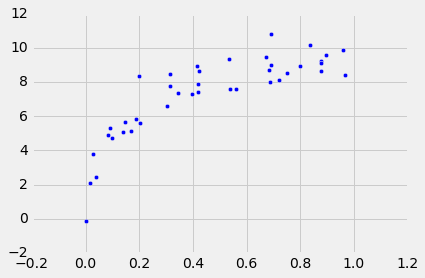

In [25]:
X, y = make_data(40, error=1)
plt.scatter(X.ravel(), y);

Now say we want to perform a regression on this data.  Let's use the built-in linear regression function to compute a fit:

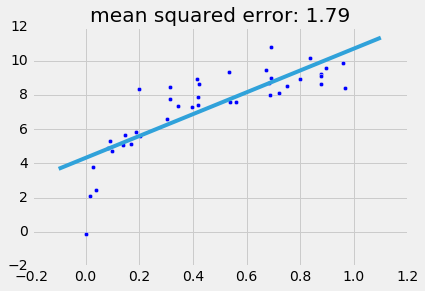

In [26]:
X_test = np.linspace(-0.1, 1.1, 500)[:, None]

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
model = LinearRegression()
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)));

We have fit a straight line to the data, but clearly this model is not a good choice.  We say that this model is **biased**, or that it **under-fits** the data.

Let's try to improve this by creating a more complicated model.  We can do this by adding degrees of freedom, and computing a polynomial regression over the inputs. Scikit-learn makes this easy with the ``PolynomialFeatures`` preprocessor, which can be pipelined with a linear regression.

Let's make a convenience routine to do this:

In [27]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

Now we'll use this to fit a quadratic curve to the data.

In [28]:
X_poly = PolynomialFeatures(degree=2).fit_transform(X)
X_test_poly = PolynomialFeatures(degree=2).fit_transform(X_test)

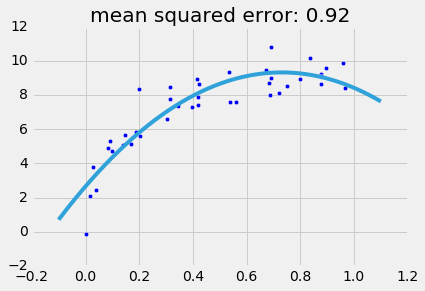

In [29]:
model = LinearRegression()
model.fit(X_poly, y)
y_test = model.predict(X_test_poly)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X_poly), y)));

This reduces the mean squared error, and makes a much better fit.  What happens if we use an even higher-degree polynomial?

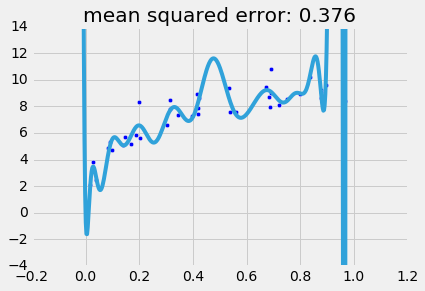

In [30]:
X_poly = PolynomialFeatures(degree=30).fit_transform(X)
X_test_poly = PolynomialFeatures(degree=30).fit_transform(X_test)

model = LinearRegression()
model.fit(X_poly, y)
y_test = model.predict(X_test_poly)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X_poly), y)))
plt.ylim(-4, 14);

When we increase the degree to this extent, it's clear that the resulting fit is no longer reflecting the true underlying distribution, but is more sensitive to the noise in the training data. For this reason, we call it a **high-variance model**, and we say that it **over-fits** the data.

Just for fun, let's use IPython's interact capability (only in IPython 2.0+) to explore this interactively:

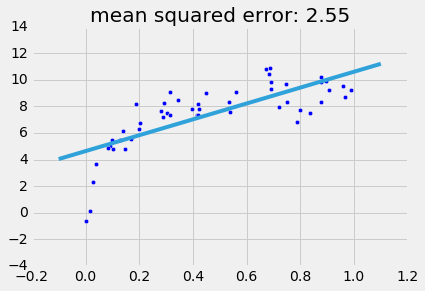

In [31]:
from IPython.html.widgets import interact

def plot_fit(degree=1, Npts=50):
    X, y = make_data(Npts, error=1)
    X_test = np.linspace(-0.1, 1.1, 500)[:, None]
    
    X_poly = PolynomialFeatures(degree=degree).fit_transform(X)
    X_test_poly = PolynomialFeatures(degree=degree).fit_transform(X_test)

    model = LinearRegression()
    model.fit(X_poly, y)
    y_test = model.predict(X_test_poly)

    plt.scatter(X.ravel(), y)
    plt.plot(X_test.ravel(), y_test)
    plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X_poly), y)))
    plt.ylim(-4, 14)

    
interact(plot_fit, degree=[1, 40], Npts=[2, 100]);

### Detecting Over-fitting with Validation Curves

Clearly, computing the error on the training data is not enough (we saw this previously). As above, we can use **cross-validation** to get a better handle on how the model fit is working.

Let's do this here, again using the ``validation_curve`` utility. To make things more clear, we'll use a slightly larger dataset:

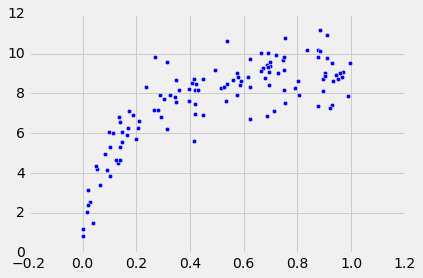

In [32]:
X, y = make_data(120, error=1.0)
plt.scatter(X, y);

In [33]:
from sklearn.learning_curve import validation_curve

/home/al/anaconda3/lib/python3.5/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [34]:
def rms_error(model, X, y):
    y_pred = model.predict(X)
    return np.sqrt(np.mean((y - y_pred) ** 2))

In [35]:
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [36]:
degree = np.arange(0, 18)
val_train, val_test = validation_curve(PolynomialRegression(), X, y,
                                       'polynomialfeatures__degree', degree, cv=7,
                                       scoring=rms_error)

Now let's plot the validation curves:

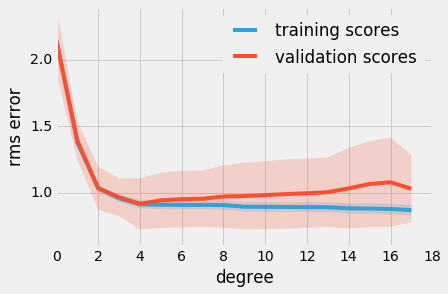

In [37]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

plot_with_err(degree, val_train, label='training scores')
plot_with_err(degree, val_test, label='validation scores')
plt.xlabel('degree'); plt.ylabel('rms error')
plt.legend();

Notice the trend here, which is common for this type of plot.

1. For a small model complexity, the training error and validation error are very similar. This indicates that the model is **under-fitting** the data: it doesn't have enough complexity to represent the data. Another way of putting it is that this is a **high-bias** model.

2. As the model complexity grows, the training and validation scores diverge. This indicates that the model is **over-fitting** the data: it has so much flexibility, that it fits the noise rather than the underlying trend. Another way of putting it is that this is a **high-variance** model.

3. Note that the training score (nearly) always improves with model complexity. This is because a more complicated model can fit the noise better, so the model improves. The validation data generally has a sweet spot, which here is around 5 terms.

Here's our best-fit model according to the cross-validation:

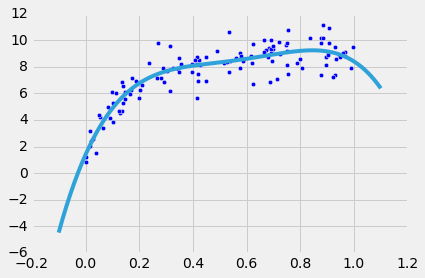

In [38]:
model = PolynomialRegression(4).fit(X, y)
plt.scatter(X, y)
plt.plot(X_test, model.predict(X_test));

### Detecting Data Sufficiency with Learning Curves

As you might guess, the exact turning-point of the tradeoff between bias and variance is highly dependent on the number of training points used.  Here we'll illustrate the use of *learning curves*, which display this property.

The idea is to plot the mean-squared-error for the training and test set as a function of *Number of Training Points*

In [39]:
from sklearn.learning_curve import learning_curve

def plot_learning_curve(degree=3):
    train_sizes = np.linspace(0.05, 1, 20)
    N_train, val_train, val_test = learning_curve(PolynomialRegression(degree),
                                                  X, y, train_sizes, cv=5,
                                                  scoring=rms_error)
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('rms error')
    plt.ylim(0, 3)
    plt.xlim(5, 80)
    plt.legend()

Let's see what the learning curves look like for a linear model:

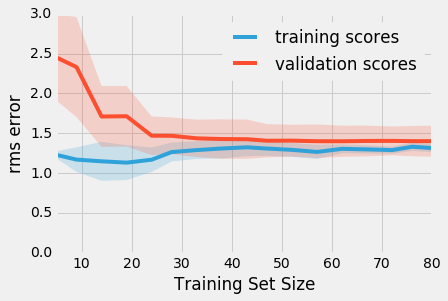

In [40]:
plot_learning_curve(1)

This shows a typical learning curve: for very few training points, there is a large separation between the training and test error, which indicates **over-fitting**.  Given the same model, for a large number of training points, the training and testing errors converge, which indicates potential **under-fitting**.

As you add more data points, the training error will never increase, and the testing error will never decrease (why do you think this is?)

It is easy to see that, in this plot, if you'd like to reduce the MSE down to the nominal value of 1.0 (which is the magnitude of the scatter we put in when constructing the data), then adding more samples will *never* get you there.  For $d=1$, the two curves have converged and cannot move lower. What about for a larger value of $d$?

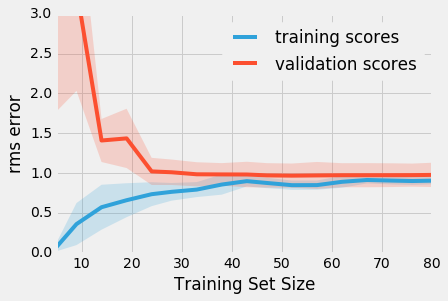

In [41]:
plot_learning_curve(3)

Here we see that by adding more model complexity, we've managed to lower the level of convergence to an rms error of 1.0!

What if we get even more complex?

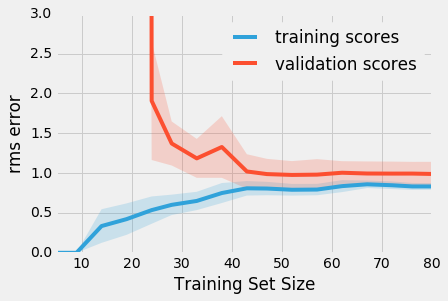

In [42]:
plot_learning_curve(10)

For an even more complex model, we still converge, but the convergence only happens for *large* amounts of training data.

So we see the following:

- you can **cause the lines to converge** by adding more points or by simplifying the model.
- you can **bring the convergence error down** only by increasing the complexity of the model.

Thus these curves can give you hints about how you might improve a sub-optimal model. If the curves are already close together, you need more model complexity. If the curves are far apart, you might also improve the model by adding more data.

To make this more concrete, imagine some telescope data in which the results are not robust enough.  You must think about whether to spend your valuable telescope time observing *more objects* to get a larger training set, or *more attributes of each object* in order to improve the model.  The answer to this question has real consequences, and can be addressed using these metrics.

# Recall, Precision and F1-Score

Intuitively, [precision](http://en.wikipedia.org/wiki/Precision_and_recall#Precision) is the ability
of the classifier not to label as positive a sample that is negative, and
[recall](http://en.wikipedia.org/wiki/Precision_and_recall#Recall) is the
ability of the classifier to find all the positive samples.

The  [F-measure](http://en.wikipedia.org/wiki/F1_score>)
($F_\beta$ and $F_1$ measures) can be interpreted as a weighted
harmonic mean of the precision and recall. A
$F_\beta$ measure reaches its best value at 1 and its worst score at 0.
With $\beta = 1$,  $F_\beta$ and
$F_1$  are equivalent, and the recall and the precision are equally important.

In [43]:
titanic = pd.read_csv('data/titanic.csv', index_col='PassengerId')

# fill missing values for Age with the median age
titanic.Age.fillna(titanic.Age.median(), inplace=True)

# define X and y
feature_cols = ['Pclass', 'Parch', 'Age']
X = titanic[feature_cols]
y = titanic.Survived

# train/test split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# train a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)

# make predictions for testing set
y_pred_class = logreg.predict(X_test)

In [44]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_class)

array([[107,  21],
       [ 52,  43]])

![f1score](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/2000px-Precisionrecall.svg.png)

In [45]:
from sklearn.metrics import precision_score, recall_score, f1_score
print('precision_score ', precision_score(y_test, y_pred_class))
print('recall_score    ', recall_score(y_test, y_pred_class))

precision_score  0.671875
recall_score     0.452631578947


### F1Score

The traditional F-measure or balanced F-score (F1 score) is the harmonic mean of precision and recall:

$$F_1 = 2 \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}}.$$

In [46]:
print('f1_score    ', f1_score(y_test, y_pred_class))

f1_score     0.540880503145


## Summary

We've gone over several useful tools for model validation

- The **Training Score** shows how well a model fits the data it was trained on. This is not a good indication of model effectiveness
- The **Validation Score** shows how well a model fits hold-out data. The most effective method is some form of cross-validation, where multiple hold-out sets are used.
- **Validation Curves** are a plot of validation score and training score as a function of **model complexity**:
  + when the two curves are close, it indicates *underfitting*
  + when the two curves are separated, it indicates *overfitting*
  + the "sweet spot" is in the middle
- **Learning Curves** are a plot of the validation score and training score as a function of **Number of training samples**
  + when the curves are close, it indicates *underfitting*, and adding more data will not generally improve the estimator.
  + when the curves are far apart, it indicates *overfitting*, and adding more data may increase the effectiveness of the model.
  
These tools are powerful means of evaluating your model on your data.